In [1]:
import sys
from pathlib import Path

# Đang ở: WorldLevel_DIP/notebooks
PROJECT_ROOT = Path.cwd().parent          # -> WorldLevel_DIP
print("PROJECT_ROOT:", PROJECT_ROOT)

# Thêm project root vào sys.path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))


PROJECT_ROOT: /home/dangkhoi/dev/Projects/WorldLevel_DIP


In [2]:
import torch
from torch.utils.data import DataLoader, random_split

from src.dataset import WLASLKeypointDataset, load_label_map
from src.model import GRUClassifier
from src.train_utils import train_one_epoch, eval_one_epoch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# Dataset + Dataloader

In [3]:
label_map = load_label_map()
num_classes = len(label_map)
print("label_map:", label_map)
print("num_classes:", num_classes)

dataset = WLASLKeypointDataset()
len(dataset)


label_map: {'good': 0, 'happy': 1, 'you': 2, 'please': 3, 'thank you': 4}
num_classes: 5


40

In [4]:
dataset[0]  # (seq, label)

(array([[ 4.1456702e-01,  4.7610170e-01,  1.4646068e-07, ...,
          4.9946961e-01,  3.8780388e-01, -1.8201174e-02],
        [ 4.1363859e-01,  4.7935694e-01,  1.6312940e-07, ...,
          4.9860236e-01,  3.8696894e-01, -1.5744463e-02],
        [ 4.1316551e-01,  4.8064965e-01,  1.5371191e-07, ...,
          4.9870607e-01,  3.8718578e-01, -1.4219910e-02],
        ...,
        [ 3.6206377e-01,  6.3459516e-01,  1.9909024e-07, ...,
          4.7199929e-01,  5.1446497e-01, -2.0739408e-02],
        [ 3.6183101e-01,  6.3490611e-01,  2.0243499e-07, ...,
          4.7201616e-01,  5.1442701e-01, -2.1313550e-02],
        [ 3.6220661e-01,  6.3482141e-01,  2.0308875e-07, ...,
          4.7336236e-01,  5.1374739e-01, -2.1346016e-02]], dtype=float32),
 0)

### Split train/val/test

In [5]:
train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)


(28, 6, 6)

In [6]:
print("len(train_ds):", len(train_ds))
print("len(val_ds):  ", len(val_ds))
print("len(test_ds): ", len(test_ds))


len(train_ds): 28
len(val_ds):   6
len(test_ds):  6


# Define model - losss - optimize

In [7]:
FEATURE_DIM = 63    # giống trong preprocess
HIDDEN_SIZE = 128
NUM_LAYERS = 1

model = GRUClassifier(
    input_size=FEATURE_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=num_classes,
    dropout=0.3,
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Train loop

In [ ]:
import matplotlib.pyplot as plt

EPOCHS = 200

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = eval_one_epoch(
        model, val_loader, criterion, device
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(
        f"[{epoch+1}/{EPOCHS}] "
        f"train_loss={train_loss:.4f}, acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f}, acc={val_acc:.4f}"
    )


[1/100] train_loss=1.6137, acc=0.2143 | val_loss=1.5936, acc=0.1667
[2/100] train_loss=1.6009, acc=0.2857 | val_loss=1.5957, acc=0.1667
[3/100] train_loss=1.5910, acc=0.2857 | val_loss=1.5947, acc=0.1667
[4/100] train_loss=1.5732, acc=0.2857 | val_loss=1.5948, acc=0.1667
[5/100] train_loss=1.5633, acc=0.3929 | val_loss=1.5998, acc=0.1667
[6/100] train_loss=1.5677, acc=0.2857 | val_loss=1.6007, acc=0.1667
[7/100] train_loss=1.5511, acc=0.3214 | val_loss=1.5963, acc=0.1667
[8/100] train_loss=1.5435, acc=0.4286 | val_loss=1.6065, acc=0.1667
[9/100] train_loss=1.5377, acc=0.3571 | val_loss=1.6353, acc=0.1667
[10/100] train_loss=1.5611, acc=0.3571 | val_loss=1.6759, acc=0.1667
[11/100] train_loss=1.5250, acc=0.3929 | val_loss=1.7311, acc=0.1667
[12/100] train_loss=1.5155, acc=0.3571 | val_loss=1.8368, acc=0.1667
[13/100] train_loss=1.4804, acc=0.3929 | val_loss=1.9103, acc=0.1667
[14/100] train_loss=1.4700, acc=0.3571 | val_loss=1.9722, acc=0.1667
[15/100] train_loss=1.4268, acc=0.3929 | va

In [9]:
from src.dataset import load_label_map
label_map = load_label_map()
idx2label = {v: k for k, v in label_map.items()}

model.eval()
samples = 0

for seq, labels in val_loader:
    seq = torch.tensor(seq, dtype=torch.float32, device=device)
    labels = torch.tensor(labels, dtype=torch.long, device=device)
    with torch.no_grad():
        outputs = model(seq)
        preds = outputs.argmax(dim=1)

    for p, t in zip(preds.cpu().numpy(), labels.cpu().numpy()):
        print("pred:", idx2label[p], " | true:", idx2label[t])
        samples += 1
        if samples >= 20:
            break
    if samples >= 20:
        break


pred: you  | true: happy
pred: good  | true: please
pred: good  | true: thank you
pred: good  | true: please
pred: happy  | true: happy
pred: good  | true: happy


/tmp/ipykernel_91982/3861490091.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(seq, dtype=torch.float32, device=device)
/tmp/ipykernel_91982/3861490091.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long, device=device)


# Evaluate on test set

In [10]:
test_loss, test_acc = eval_one_epoch(model, test_loader, criterion, device)
print("Test loss:", test_loss)
print("Test acc :", test_acc)


Test loss: 1.005867838859558
Test acc : 0.3333333333333333


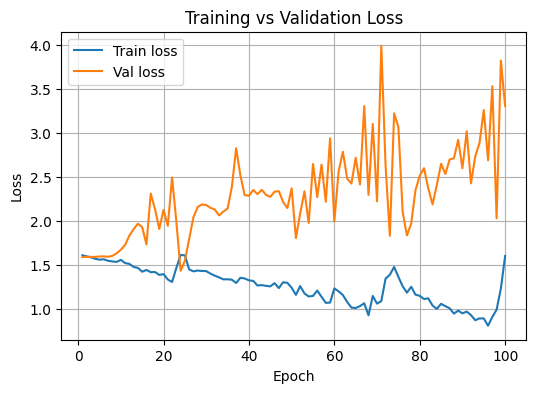

In [11]:
%matplotlib inline

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


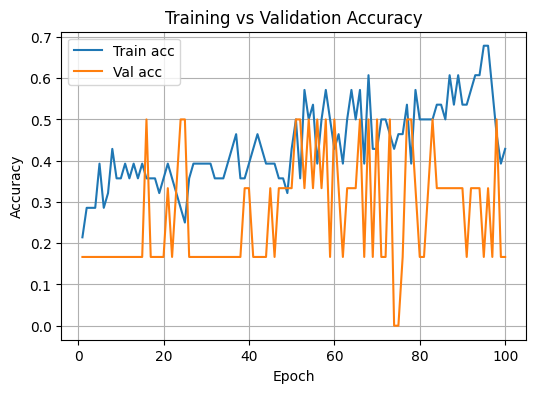

In [12]:
plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"],   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# torch.save(model.state_dict(), "word_level_gru.pth")
